In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

import scipy
import matplotlib.pyplot as plt

import utils.adversarial as adv
import utils.dataloaders as dl
import utils.models as models
import utils.gmm_helpers as gmm_helpers

log = lambda x: np.log(x)
import utils.dataloaders as dl

In [2]:
train_loader = dl.MNIST(train=True, augm_flag=True)

In [3]:
file = 'gmm__PCAMNIST_lam0.0_n100_lr0.001_lrgmm1e-05_augm_flagTrue_train_typeCEDA_GMM_OUTgrad_vars mu var_OUT.pth'
model = torch.load('SavedModels/' + file)

In [4]:
seed = torch.rand(100,1,28,28)

In [5]:
gmm = model.mm
gmm_out = model.mm_out

classes = 10
lam = 1.
f = 1.1
b = lam * (f-1.) / (classes-f)


batch_bounds = []

for x in seed:
    a = gmm_helpers.get_b_out(0., x, gmm, gmm_out, b)
    if a>=0:
        batch_bounds.append(0.)
    else:
        batch_bounds.append( scipy.optimize.brentq(gmm_helpers.get_b_out, 0, 
                                                  10000., args = (x, gmm, gmm_out, b),
                                                  maxiter=10000) )

In [6]:
outliers = []
for data, _ in train_loader:
    dist_real = model.mm.metric(seed.view(-1,784)[:,None,:], data.view(-1, 784)[None,:,:]).min(1)[0]
    outs = (torch.tensor(batch_bounds) > dist_real).float().sum()
    if outs>0.:
        print(outs)
        outliers.append(data)

In [7]:
data = outliers[0]
dist_real = model.mm.metric(seed.view(-1,784)[:,None,:], data.view(-1, 784)[None,:,:]).min(1)[0]
discrepancy = (torch.tensor(batch_bounds) < dist_real)

IndexError: list index out of range

In [ ]:
data, label = next(iter(train_loader))

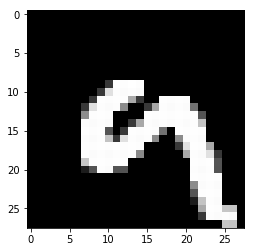

In [70]:
plt.imshow(data[87].squeeze().numpy(), cmap='gray')

In [7]:
outliers = []
while len(outliers)==0:
    batch_bounds = []
    seed = torch.rand(100,1,28,28)

    for x in seed:
        a = gmm_helpers.get_b_out(0., x, gmm, gmm_out, b)
        if a>=0:
            batch_bounds.append(0.)
        else:
            batch_bounds.append( scipy.optimize.brentq(gmm_helpers.get_b_out, 0, 
                                                      10000., args = (x, gmm, gmm_out, b),
                                                      maxiter=10000) )
    for data, _ in train_loader:
        dist_real = model.mm.metric(seed.view(-1,784)[:,None,:], data.view(-1, 784)[None,:,:]).min(1)[0]
        outs = (torch.tensor(batch_bounds) > dist_real).float().sum()
        if outs>0.:
            print(outs)
            outliers.append(data)

tensor(1.)


In [8]:
data = outliers[0]
dist_real = model.mm.metric(seed.view(-1,784)[:,None,:], data.view(-1, 784)[None,:,:]).min(1)[0]

In [12]:
idx_seed = (torch.tensor(batch_bounds) > dist_real).max(0)[1]

In [13]:
seed2 = torch.stack([seed[idx_seed], seed[idx_seed]], 0)

In [21]:
idx_sample = (model.mm.metric(seed.view(-1,784)[:,None,:], data.view(-1, 784)[None,:,:])[idx_seed]<batch_bounds[idx_seed]).max(0)[1]

In [15]:
batch_bounds[idx_seed]

68.86056137085018

In [24]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

import scipy

import utils.adversarial as adv
import utils.dataloaders as dl
import utils.models as models
import utils.gmm_helpers as gmm_helpers

log = lambda x: np.log(x)

In [25]:
def aggregate_adv_stats_out(model_list, gmm, gmm_out, device, shape, classes=10, 
                            batches=10, batch_size=100, steps=200, out_seeds=False,
                            restarts=10, alpha=1., lam=1.):
    
    pca = models.MyPCA(gmm.metric.comp_vecs.t(), gmm.metric.singular_values, shape)
    
    f = 1.1
    b = lam * (f-1.) / (classes-f)

    bounds = []
    stats = []
    samples = []
    seeds = []
    
    seed = seed2.to(device)
    
    batch_bounds = []
    batch_samples = []

    for x in seed:
        a = gmm_helpers.get_b_out(0., x, gmm, gmm_out, b)
        if a>=0:
            batch_bounds.append(0.)
        else:
            batch_bounds.append( scipy.optimize.brentq(gmm_helpers.get_b_out, 0, 
                                                   10000., args = (x, gmm, gmm_out, b),
                                                      maxiter=10000) )
    batch_bounds = torch.tensor(batch_bounds, device=device)
    bounds.append(batch_bounds.clone().cpu())

    batch_stats = []
    for i, model in enumerate(model_list):
        model.eval()
        adv_noise, _ = adv.gen_pca_noise(model, device, seed, pca, 
                                         epsilon=batch_bounds, perturb=True, 
                                         restarts=restarts, steps=steps, alpha=alpha)
        out = model(adv_noise).max(1)[0].detach().cpu().clone()

        batch_stats.append(out)
        batch_samples.append(adv_noise.detach().cpu())

    seeds.append(seed.cpu())

    batch_samples = torch.stack(batch_samples, 0)
    batch_stats = torch.stack(batch_stats, 0)
    stats.append(batch_stats.clone())
    samples.append(batch_samples.clone())

    seeds = torch.stack(seeds, 0)
    samples = torch.stack(samples, 0)
    stats = torch.cat(stats, -1)
    bounds = torch.cat(bounds, 0)
    
    return stats, bounds, seeds, samples

In [26]:
import model_paths
import model_params as params
import utils.traintest as tt

dataset = 'MNIST'
device = torch.device('cuda:4')

model_params = params.params_dict[dataset]()
model_path = model_paths.model_dict[dataset]() 
model_list = [torch.load(file).to(device) for file in model_path.file_dict.values()]


model_list = model_list[:-1]

accuracies = [tt.test(model, device, model_params.test_loader, min_conf=.001)[0]
              for model in model_list]

shape = next(iter(model_params.cali_loader))[0][0].shape


gmm = model_list[-1].mm
gmm_out = model_list[-1].mm_out

In [27]:
steps = 500
restarts = 50
alpha = 3.

results = aggregate_adv_stats_out(model_list, gmm, gmm_out, device, 
                         shape, classes=model_params.classes, 
                         steps=steps, restarts=restarts, alpha=alpha)

In [28]:
stats, bounds, seeds, samples = results

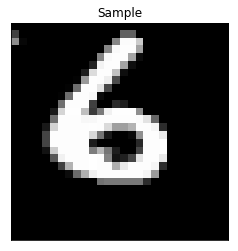

In [30]:
f = plt.figure()
plt.title('Sample')
plt.imshow(data[idx_sample][0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

f.savefig('Export/' + 'Sample' + '.eps')
f.savefig('Export/' + 'Sample' + '.png')

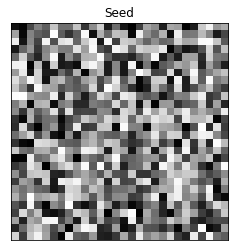

In [31]:
f = plt.figure()
plt.title('Seed')
plt.imshow(seed2[0][0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

f.savefig('Export/' + 'Seed' + '.eps')
f.savefig('Export/' + 'Seed' + '.png')

In [32]:
key = ['Base', 'MCD', 'GAN', 'ODIN', 'Maha', 'ACET', 'OE', 'CCU', 'CCUs']

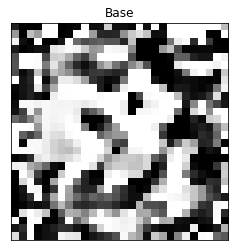

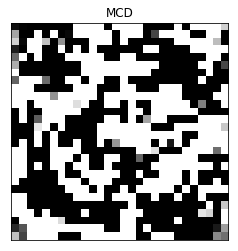

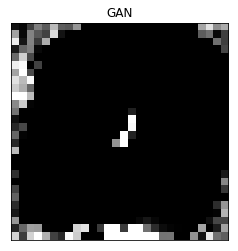

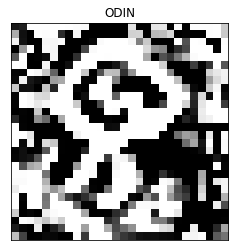

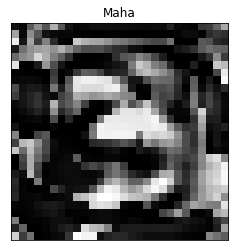

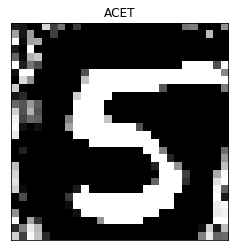

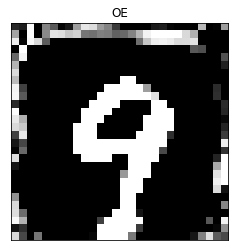

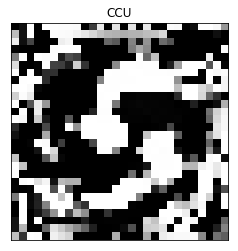

In [33]:
for i in range(8):
    f = plt.figure()
    plt.title(key[i])
    plt.imshow(samples.squeeze()[i][0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    f.savefig('Export/' + key[i] + '.eps')
    f.savefig('Export/' + key[i] + '.png')